# Scaling with domain size 2D

In [1]:
from jwave.geometry import Domain
from jax import numpy as jnp
from jwave.geometry import Medium,TimeAxis,_points_on_circle, Sensors, _circ_mask
from jwave.acoustics import ongrid_wave_propagation
from timeit import timeit

In [17]:
N0 = 2048

In [18]:
N, dx = (N0, N0), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)
sound_speed = jnp.ones(N)*1500
medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20)

sensors_positions = (jnp.array([35]), jnp.array([40]))
sensors = Sensors(positions=sensors_positions)

mask1 = _circ_mask(N, 8, (N0//2,N0//2))
p0 = 5.*mask1

In [19]:
time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=1.998e-5)

params, j_solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    output_t_axis = time_axis,
    sensors=sensors,
    backprop=False,
    p0 = p0
)

In [20]:
time_axis.to_array().shape

(1000,)

In [21]:
_ = j_solver(params)

In [22]:
%timeit j_solver(params).block_until_ready()

6.66 s ± 45.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
steps = [64, 92, 128, 192, 256, 512, 784, 1024, 2048]

# Times in ms
mean_times = [101, 119, 112, 119, 143, 387,  1080, 1660, 6660]
std_times =  [.45, .66, .43, .66, .39, 1.16, 1.33, 2.11, 45]

In [24]:
!nvidia-smi

Thu Dec  2 20:07:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0 Off |                  N/A |
| 60%   73C    P0    38W / 125W |   7432MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

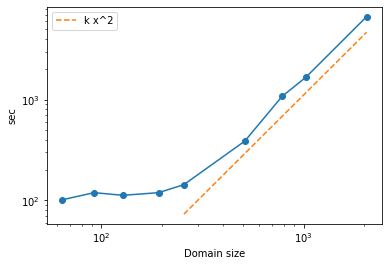

In [30]:
from matplotlib import pyplot as plt

plt.errorbar(steps, mean_times, yerr=std_times, marker='o')
x_sq = list(map(lambda x: float(x/30)**2, steps[4:]))
plt.plot(steps[4:], x_sq, linestyle='--', label="k x^2")

plt.ylabel("sec")
plt.xlabel("Domain size")
plt.xscale("log")
plt.yscale("log")
plt.legend()